# 2022 Systematic Trading Education Ceritificate Skeleton Code Lecture 1


## Lecture 1
In this lecture we will be focussing on developing code for both a relative and time series momentum strategies. This lecture will also focus on introducing QT Capital's own skeleton code for backtesting strategies. Note that in order to access financial price data we use the module [yfinance](https://pypi.org/project/yfinance/), which has to be first installed using the Python command pip install done below. The yfinance module allows for the easy pulling of data from yahoo finance which will provide us with asset price data for the first and second lectures.

In [54]:
#pip install yfinance

In [55]:
# the usual imports along with yfinance and a few others
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime

## The Parent Class and Evaluation method.
In the code below we define the Strategies class which is a class containing all basic features that our individual backtesting strategy classes will inherit from.

These basic features include:

- the **init method** which defines the asset tickers that the strategy will be focussed on.
- the **import data method** that will import data for a given start and end date using the yfinance module as mentioned earlier.
- the **backtest method** that defines the class variable `self.strat` which is the pandas data frame of values representing the strategy. This is left empty as it will be filled in in the child class.
- the **evaluate method** which calculates the cumulative returns of the given strategy, plots a chart of the cumulative returns and calculates the sharpe ratio of the strategy.
(note that one task this week will be to write code in the evaluate method so that it also returns the sortino ratio)

## Task 3: Calculation of the Sortino Ratio
As was shown in the powerpoint slides for lecture one we have 2 methods for evaluting risk adjusted returns; the Sharpe and Sortino ratios. The code for calculating the Sharpe ratio has already been written below and the task is to then adapt this code to calulate the Sortino ratio (where +ve volatility is ignored).

In [56]:
class Strategies():
  """
  A class that contains code that strategies later on will inherit from.
  params:
  -----
  codes = list of stock short codes
  -----
  """
  def __init__(self, codes):
    self.codes = codes
    self.strat = pd.DataFrame()
    self.data = pd.DataFrame()

  def import_data(self, start_date, end_date):
    """downloads all data for each backtest from yahoo Finance."""
    data = yf.download(self.codes, start_date, end_date)
    # if only one stock code is entered data is reformated so that
    # it is the same format as when multiple stocks are entered
    if len(self.codes) == 1:
      data.columns = [data.columns, self.codes*len(data.columns)]
    #returns data where any row containing NAN values is removed
    return data.dropna()

  def backtest(self, start_date, end_date):
    """
    Returns a list with elements of a time series' from yahoo finance as well as
    an array of values between -1 and 1 that represent the strategy over the giv
    en period with 1 representing a long postion in one stock, 0 representing a
    neutral postion and -1 representing a short position.
    params:
    -----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    -----
    """
    # sets up a dataframe to contain all strategy info for each stock at each 
    # time index
    self.data = self.import_data(start_date, end_date)
    self.strat = pd.DataFrame(data = np.zeros([len(self.data), len(self.codes)]), columns = self.codes, index = self.data.index)

  
  def evaluate(self, start_date, end_date, fig_strat=True, fig_other=False, percentage_risk_free_rate = 0.1, **kwargs):
    """
    returns a dataframe with columns icluding the daily returns of the portfolio,
    the cumulative returns, the sharpe ratio and all relevant plots of both the 
    stock price of each stock 
    and the strategy.
    params:
    ----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    fig = boolean variable that can be used to produce figures
    risk_free_rate = average rate of return on a very safe government issued bond
                     used to calculate the sharpe ratio with
    **kwargs are any specific keyword arguments that can be passed to the
    backtesting function to allow for comparison of the backtest for different
    possible parameters defined in the subclass.
    ----
    """
    # run the backtest function and define the stock price data to be once again
    # data and the signals strat
    self.strat = self.backtest(start_date, end_date, **kwargs)

    # convert the monthly risk free rate to the daily rate for use
    # when calculating Sharpe and sortino ratios
    daily_rate = (1+ percentage_risk_free_rate/100)**(1/20) - 1
    
    # sets up a new dataframe which will give the returns of the portfolio
    return_df = pd.DataFrame(columns= ["daily returns", "cumulative returns"],
                                  index = self.data.index)
    return_df["daily returns"][0] = 0
    
    # loops through the remaining dates and calculates the return across 
    # the portfolio
    for i in range(1, len(self.data)):
      return_df["daily returns"][i] = sum(100*self.strat[c][i-1]*(self.data["Adj Close"][c][i] - self.data["Adj Close"][c][i-1])/self.data["Adj Close"][c][i-1] for c in self.codes)
    # calculates the cumulative return for each date
    return_df["cumulative returns"] = ((return_df["daily returns"]/100+1).cumprod()-1)*100
    return_df.dropna()

    # calculates the length of time for which the strategy is inactive to begin with
    zero_count = 0
    while True:
      if sum(abs(self.strat[c].iloc[zero_count]) for c in self.codes):
        break
      zero_count += 1
    
    # calculates the Sharpe ratio not including the first period of inactivity
    sharpe  = ((return_df["daily returns"][zero_count:].sum()/100 - 
                     len(return_df[zero_count:]) * daily_rate) /
                    return_df["daily returns"][zero_count:].std())


    #sortino = None ######### INSERT YOUR CODE HERE ##########
    ######## - HINT: ADAPT THE CODE FOR THE SHARPE RATIO ##########
    sortino = ((return_df["daily returns"][zero_count:].sum()/100 - 
                len(return_df[zero_count:])* daily_rate) /
                return_df["daily returns"][zero_count:].loc[return_df["daily returns"][zero_count:]<=0].std())
    
    
    # plots figures if fig TRUE
    if fig_strat:
      # plot of strategy returns
      plt.figure(figsize = (15,5))
      plt.title("Strategy Backtest from "+ start_date+" to "+end_date)
      plt.plot(return_df["cumulative returns"])
      plt.grid()
      plt.show()

    if fig_other:
      # plot of all individual stocks
      for c in self.codes:
        plt.figure(figsize = (15,5))
        plt.title("Buy and hold from "+ start_date+" to "+end_date+" for "+str(c))
        plt.plot(((self.data["Adj Close"][c].pct_change()+1).cumprod()-1)*100)
        plt.grid()
        plt.show()
    print(sharpe, sortino)
    return [return_df, sharpe, sortino]


## Strategy Specific Classes
Each strategy will have to have at a minimum a specific backtesting method defined in the subclass. This method is where the trading algorithm will be implemented and will return a pandas `DataFrame` with an index of all trading dates, columns for each stock in the backtest and data containing values between -1 and 1 representing the positon in each asset at each date.

## Buy and Hold Implementation
The first strategy example that we will briefly look at is simply buying and holding each selected asset with an equal weighting. This is acheived by first defining a pandas dataframe full of ones and then dividing through by the number of tickers (or codes). Although this isn't much of an algorithm, it is useful for seeing how the skeleton code works. 

In [57]:
class StrategyBuyAndHold(Strategies):
    """
    This strategy as the name suggests buys and holds an equal amount of each security
    """
    def backtest(self, start_date, end_date):
      Strategies.backtest(self, start_date, end_date)
      # creates a normalized set of weightings representing a buy and hold strat
      # with each column summing to one 
      return pd.DataFrame(data = (np.ones([len(self.data), len(self.codes)])/len(self.codes)), columns = self.codes)
      


[*********************100%***********************]  1 of 1 completed


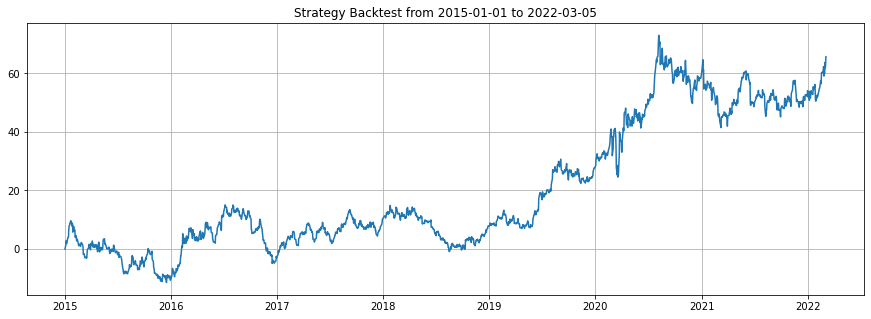

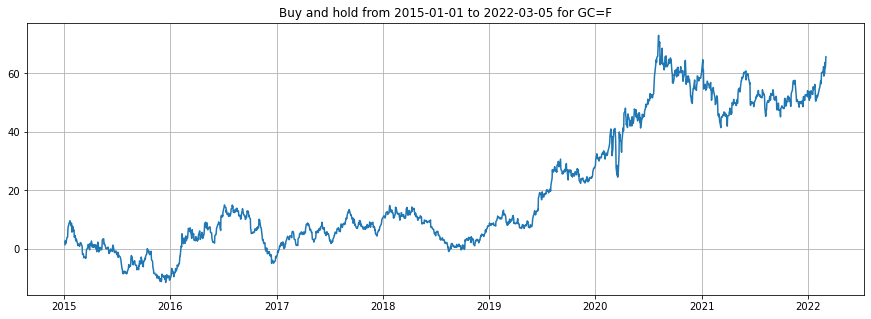

0.5306756949537962 0.7339548443462579


[           daily returns cumulative returns
 Date                                       
 2015-01-02             0                0.0
 2015-01-05      1.509277           1.509277
 2015-01-06      1.279178           2.807761
 2015-01-07      -0.71353           2.074197
 2015-01-08     -0.181724           1.888704
 ...                  ...                ...
 2022-02-28      0.683807          60.151773
 2022-03-01      2.263873          63.777405
 2022-03-02     -1.106878          61.964589
 2022-03-03      0.702796          63.102869
 2022-03-04      1.587053          65.691398
 
 [1804 rows x 2 columns],
 0.5306756949537962,
 0.7339548443462579]

In [58]:
testbh = StrategyBuyAndHold(["GC=F"])
testbh.evaluate("2015-01-01","2022-03-05", fig_other =True)

## Task 1 Time Series Momentum Strategy
The aim of this task is to implement a backtest for the time series momentum strategy:

- This strategy will take a postion in every asset in the given basket.
- If an asset has a negative historic return then a short position is taken and if it has a positive historic return then a long position is taken.
- The lookback period for which returns are calculated is the previous `t` days. 
- We will also only adjust our portfolio weights every `q` days.
Note the first date that we can calculate weights will be on date `t + 1` so we aim to adjust our portfolio weights every q days after this.
- We then aim to normalize our weights by ensuring the sum of the absolute values of all weights on any given date is 1.

In [65]:
class StrategyTimeSeriesMomentum(Strategies):
    """
    Implementation of a TS momentum strategy.
    params:
    ------
    start_date, end_date strings of dates
    t = lookback period length for calculating momentum of each stock
    q = time length between portfolio adjustements
    ------
    """
    def backtest(self, start_date, end_date, q=10, t=50):
      # imports all code from the parent class
      Strategies.backtest(self, start_date, end_date)
      # USE A FOR LOOP to loop through all remaining time vals
      # hint start at time t+1 and use i as the index in the for loop
      ####### ENTER CODE HERE #########
      for i in range(t, len(self.data)):
        # now use an IF LOOP to test for if a given date value is a day to adjust the portfolio
        # hint use the modulo operator to compare the date to q
        ####### ENTER CODE HERE #########
        if not (i-t)%q:
          # for each time step define a variable self.signals that is a pd Series with 
          # index of stock codes, data equal to the percentage returns over the previous
          # t time steps.
          ####### ENTER CODE HERE #########
          signals = pd.Series(data=(100*(self.data["Adj Close"][c][i-1]-self.data["Adj Close"][c][i-t])/self.data["Adj Close"][c][i-t] for c in self.codes), index = self.codes )
          self.strat.iloc[i] = np.sign(signals)
          row_sum = sum((abs(self.strat[c][i]) for c in self.codes))

          if row_sum:
            self.strat.iloc[i] /= row_sum


        else:
          self.strat.iloc[i] = self.strat.iloc[i-1]
      print(self.strat)
      return self.strat



            

          # for each time step define a variable self.signals that is a pd Series with 
          # index of stock codes, data equal to the percentage returns over the previous
          # t time steps.
          ####### ENTER CODE HERE #########

          # Now to assign a strategy weight at each time step.
          # for a row with index i assign self.strat[i][c] the value 1 for column [c]
          # if the value of signal[c] is positive and -1 if it is negative     
          ###### ENTER CODE HERE #########

          # normalize each row of strat such that the sum of absolute weights is 1
          # also if the sum of abs weights is 0 then do nothing
          ###### ENTER CODE HERE #########
          
        # if the portfolio is not adjusted at time step i then do nothing
        # the ith row of self.strat should be set to the value of the (i-1)th
        ####### ENTER CODE HERE #########

      #return self.strat

[*********************100%***********************]  6 of 6 completed
               ^FTSE      GC=F      ZC=F      AMZN    SIE.DE     SIEGY
Date                                                                  
2018-01-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2018-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2018-01-04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2018-01-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2018-01-08  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
...              ...       ...       ...       ...       ...       ...
2022-02-28  0.166667  0.166667  0.166667 -0.166667  0.166667 -0.166667
2022-03-01  0.166667  0.166667  0.166667 -0.166667 -0.166667 -0.166667
2022-03-02  0.166667  0.166667  0.166667 -0.166667 -0.166667 -0.166667
2022-03-03  0.166667  0.166667  0.166667 -0.166667 -0.166667 -0.166667
2022-03-04  0.166667  0.166667  0.166667 -0.166667 -0.166667 -0.166667

[1014 r

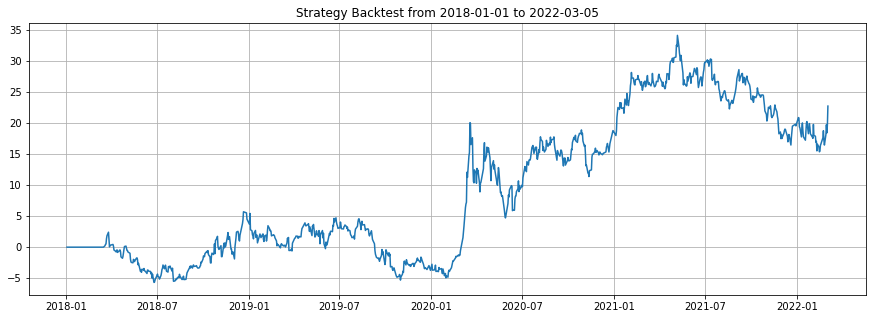

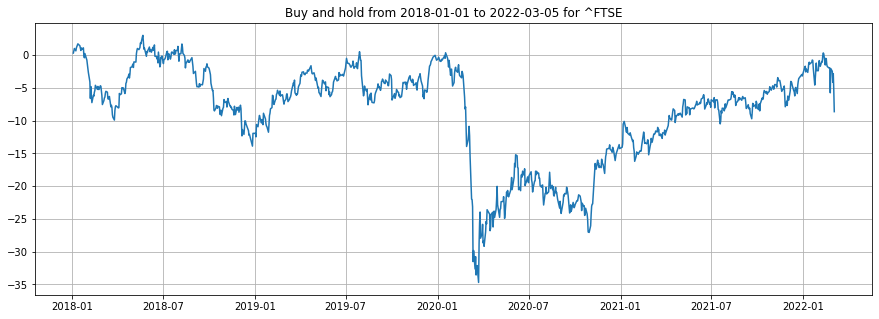

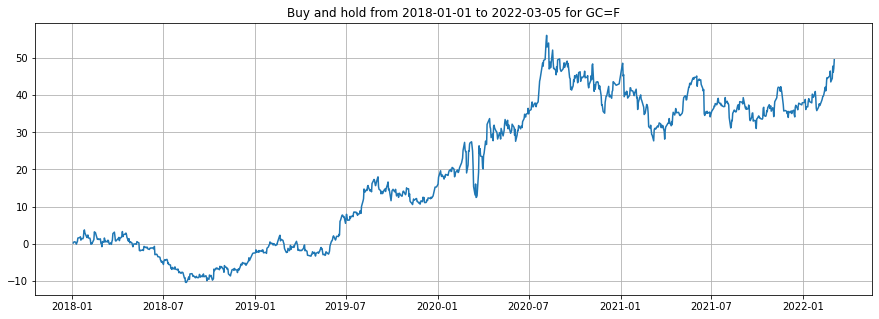

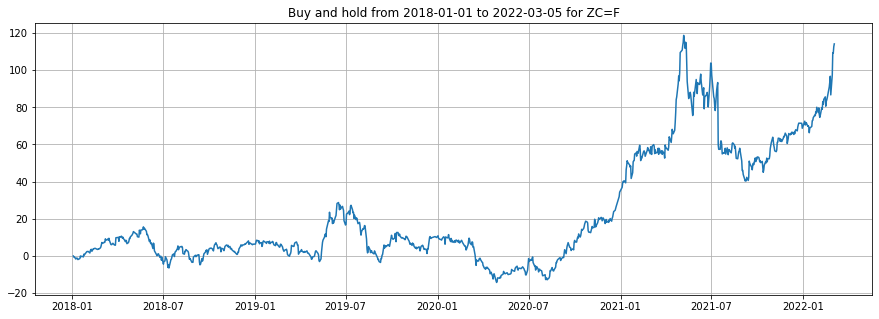

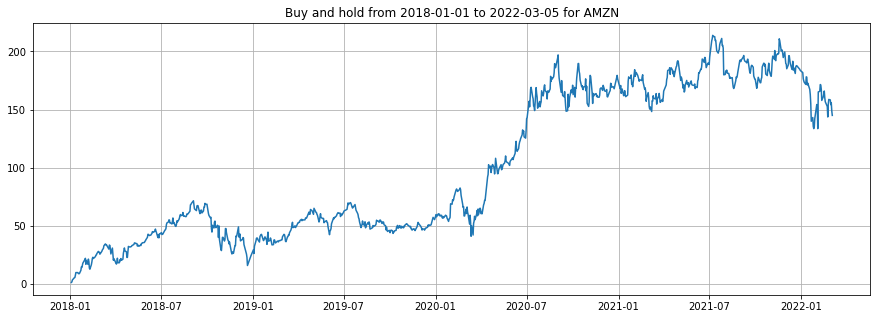

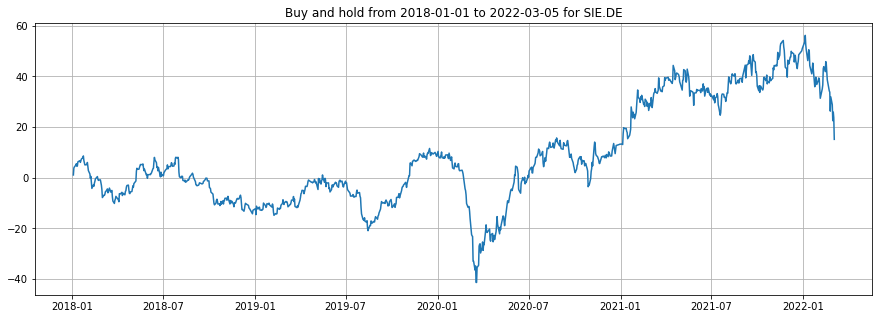

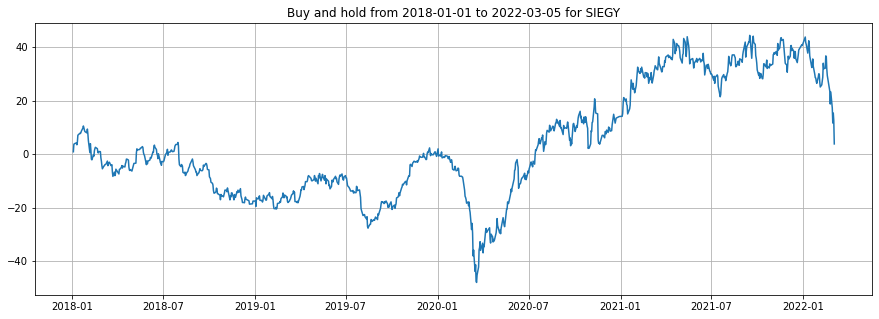

0.2366724009168252 0.33840981391787917


[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-28      1.444062          18.152226
 2022-03-01      1.348912          19.745995
 2022-03-02     -1.096622          18.432834
 2022-03-03      1.116848          19.755549
 2022-03-04      2.503532          22.753668
 
 [1014 rows x 2 columns],
 0.2366724009168252,
 0.33840981391787917]

In [66]:
## RUN THIS FOR TESTING ##
testTSM = StrategyTimeSeriesMomentum(["^FTSE","GC=F","ZC=F","AMZN","SIE.DE","SIEGY"])
testTSM.evaluate("2018-01-01","2022-03-05", t=50, fig_other =True)

## Task 2: Relative Momentum Strategy
The aim of this task is to implement a backtest for the relative momentum strategy:

- For each date the strategy will take a long postion in the `p` best previous performing stocks and a short position in the `p` worst performing stocks. 
- The lookback period for which performance will be judged will be the previous `t` days. 
- We will also only adjust our portfolio weights every `q` days.
Note the first date that we can calculate weights will be on date `t + 1` so we aim to adjust our portfolio weights every `q` days after this.

For the worst performing stocks the weights should be negative and for the best performing stocks weights positive such that the sum of the absolute values across each row of the strategy weights is equal to 1! i.e the weights for the worst stocks are -1/(2p) and for the best `p` stocks 1/(2p). All other weights are 0.

For this algorithm performance is measured by cumulative returns.

In [61]:
class StrategyRelativeMomentum(Strategies):
    """
    Implementation of a relative momentum strategy.
    params:
    ------
    start_date, end_date strings of dates
    p = half the number of stocks a postion a is taken in
    t = lookback period length for calculating momentum of each stock
    ------
    """
    def backtest(self, start_date, end_date, p=2, q=14, t=50):
      # imports all code from the parent class
      Strategies.backtest(self, start_date, end_date)
      # Similarly to the TS strat loop through all time steps i and decide a value
      # is a portfolio changing time.
      
      ######## INSERT CODE HERE #############
      for i in range(t, len(self.data)):
        ######## INSERT CODE HERE #############
        if (i-t) % q == 0:
          # as before define signals but sort the values in ascending order
          ######## INSERT CODE HERE #############
          signals = pd.Series(data=(100*(self.data["Adj Close"][c][i-1]-self.data["Adj Close"][c][i-t])/self.data["Adj Close"][c][i-t] for c in self.codes), index = self.codes).sort_values() 
          # select and loop through the p code names with a long position
          ######## INSERT CODE HERE #############
          for c in signals[-p:].keys():
              # for each of these codes assign the appropriate weighting to strat (long positions)
              ######## INSERT CODE HERE #############
              self.strat[c][i] = 1/(2*p)
            
            # DO the same for each of the p code names with short positions
            ######## INSERT CODE HERE #############
          for c in signals[:p].keys():
            self.strat[c][i] = -1/(2*p)
              ######## INSERT CODE HERE #############

        # if the portfolio is not adjusted at time step i then do nothing
        else: 
          self.strat.iloc[i] = self.strat.iloc[i-1]
        ######## INSERT CODE HERE #############
      return self.strat




[*********************100%***********************]  6 of 6 completed


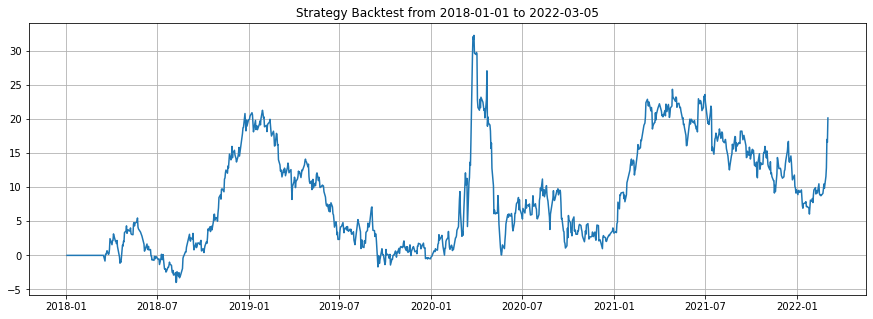

0.17858038589486547 0.2505336911974225


[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-28      1.569238          11.560048
 2022-03-01      1.157458          12.851309
 2022-03-02       3.68213          17.006641
 2022-03-03     -0.357653          16.588163
 2022-03-04      3.054493          20.149341
 
 [1033 rows x 2 columns],
 0.17858038589486547,
 0.2505336911974225]

In [62]:
testRM = StrategyRelativeMomentum(["HG=F","GC=F","ZC=F", "SI=F", "PA=F","RB=F"])
testRM.evaluate("2018-01-01","2022-03-05", t=50)

## Task 4: RSI Momentum  Strategy with Weighting Extension
This task involves calculating the RSI for each stock and then using this value as a trading signal. From the Powerpoint Slides the formula for the RSI is given by:
 $$\text{RSI} = 1 - \frac{1}{\left(1+\text{abs}\left(\frac{\text{average of previous gains}}{\text{average of previous losses}}\right)\right)}$$

The value of the RSI ranges from 0 to 1.

The RSI is a useful oscillator that indicates the following few things:
If the value of the RSI is close to 0 then this indicates that the asset is underpriced and the asset should be bought. If the RSI is close to one then this indicates it is over priced and the asset should be sold. These low and high boundary values of the RSI are 0.3 and 0.7 respectively


This unweighted algorithm will do the following:
  - Calculate the RSI at each date.
  - If the RSI is less than 0.3 then enter a long position
  - If the RSI is greater than 0.7 then enter a short position
  - If the RSI is somewhere in between then keep the same position as at the previous date
  - The lookback period for which previous average returns will be calculated is given by the parameter `t`
  - The Boolean parameter weighting will, if True, implement a type of user defined weighting strategies or, if False, will weight each stock equally.
  - Note that we want the weightings of the portfolio to only change when the RSI drops below 0.3 or rises above 0.7.

The weighted algorithm will:
 - adjust the portfolio every `q` days where `q` is an extra parameter.
 - weightings will be assigned based on some function of the RSI values.

### Weighting Functions
The weighting function $\text{w(x)}$ in this case will simply be an algebraic function of the RSI value. It is important that this function  maps as follows $\text{w}\left([0,1]\right)\rightarrow [-1,1]$ with $\text{w}(0) > 0,\text{w}(1) < 0$.

Some common examples of these types of weighting functions include various polynomials including the following simple linear polynomial symmetric about $\frac{1}{2}$.
$$w(x) = k_1\left(\frac{1}{2}-x\right)$$

(note the constant $k_1$ above is not necassry to be calculated as when coding we will normalize all the weightings)

One problem with the above function however is that it is symmetric and an investor may wish to use a weighting function that protects against the risks of short selling. So may want to consider the following weighting function:
$$w(x) = k_1\left(\frac{1}{2}+ϵ-x\right) \text{for } ϵ>0$$

Note other weighting methods are also possible that do not involve weighting or smoothing functions but instead use historic data to produce a weighting method.
One such example methods of inverse volatility weighting where i,e assets with a smaller previous standard deviations over a lookback period have a higher weighting.

Note also that the weighting function need not only be a function of the current RSI value but could also depend on previous RSI values.



In [63]:
class StrategyRSI(Strategies):

  def backtest(self, start_date, end_date, t=14, q=14, weighting = False):
    Strategies.backtest(self, start_date, end_date)
    
    # set up a dataframe self.RSI
    RSI = pd.DataFrame(data = np.zeros([len(self.data), len(self.codes)]),
                              columns = self.codes, index = self.data.index)

  
    # loop through each index using a for loop with index i
    ######## INSERT CODE HERE #############
    for i in range(t, len(self.data)):
      # define data_pct_change as a function that calulates the pct change over the previous
      # t time periods. Hint use .pct_change() and dont convert to a percentage after.
      ######## INSERT CODE HERE #############
      data_pct_change = self.data["Adj Close"][i-t:i].pct_change() 
      # define numerator as the numerator of the RSI values for each asset at time i.
      # package these values into a pd series with index self. codes
      ######## INSERT CODE HERE #############
      num = pd.Series(data = (data_pct_change[c][(data_pct_change[c]>=0)].mean() for c in self.codes), index = self.codes)
      # similarly define denominator
      ######## INSERT CODE HERE #############
      denom = pd.Series(data = (data_pct_change[c][data_pct_change[c]<=0].mean() for c in self.codes), index = self.codes)

      # loop through self.codes
      ######## INSERT CODE HERE #############
      for c in self.codes:
        # calculate the RSI value for each asset at time i.
        # hint carefully consider any potential NaN values.
        ######## INSERT CODE HERE #############
        if num.isnull()[c]:
          RSI[c][i]=0
        elif denom.isnull()[c]:
          RSI[c][i] = 1
        else:
          RSI[c][i] = 1 - 1/(1-num[c]/denom[c])
      
        # if no weighting scheme is used set self.strat to be 1 if RSI value < 0.3
        # and self.strat to be -1 for RSI > 0.7 do this for each code at time step i
        # if neither condition is satisfied then set the value equal to previous
        ######## INSERT CODE HERE #############
        if not weighting:
          if RSI[c][i] < 0.3:
            self.strat[c][i] = 1
          elif RSI[c][i] > 0.7:
            self.strat[c][i] = 0
          else:
            self.strat[c][i] = self.strat[c][i-1]





        # else implement a weighting scheme with the function that re-adjusts self.strat every q days
        # to be 0.8 - RSI 
        ######## INSERT CODE HERE #############
        else: 
          if (i-t) % q:
            self.strat.iloc[i] = (0.8-RSI.iloc[i])
          else:
            self.strat.iloc[i] = self.strat.iloc[i-1]

      
      # as before normalize the rows
      ######## INSERT CODE HERE #############

    row_sum = sum(abs(self.strat.iloc[i]))
    
    if row_sum:
      self.strat.iloc[i] /= row_sum



        
    return self.strat

[*********************100%***********************]  8 of 8 completed


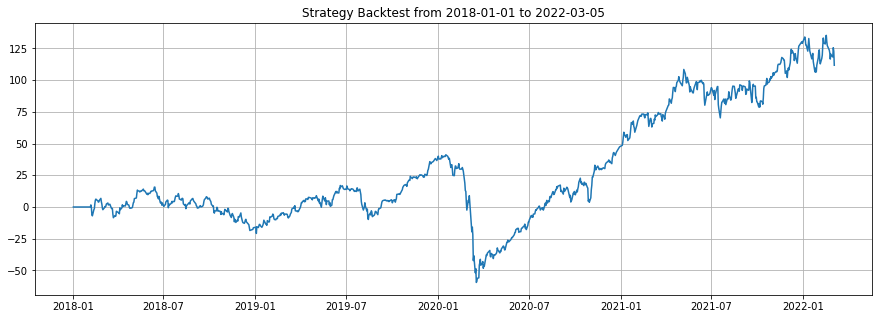

0.4009291041076376 0.4299666013216522


[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-28     -0.907464         118.502038
 2022-03-01     -0.104508         118.273685
 2022-03-02      3.340339         125.564765
 2022-03-03     -1.233516         122.782388
 2022-03-04     -4.963763         111.723998
 
 [1014 rows x 2 columns],
 0.4009291041076376,
 0.4299666013216522]

In [64]:
testRSI = StrategyRSI(["^FTSE","^GSPC","AAPL","GC=F","ZC=F","HG=F","SIEGY","SIE.DE"])
testRSI.evaluate("2018-01-01","2022-03-05", t=21, weighting= True, )